In [16]:
from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']:
    checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
    print(f'{model_name} is downloaded to {checkpoint_path}.')

RN50 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-RN50.pt.


ViT-B-32 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt.


ViT-L-14 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt.


In [17]:
model_name = 'RN50' # 'RN50' or 'ViT-B-32' or 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

path_to_your_checkpoints = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(f"{path_to_your_checkpoints}/RemoteCLIP-{model_name}.pt", map_location="cpu")
message = model.load_state_dict(ckpt)
print(message)
model = model.cuda().eval()

<All keys matched successfully>


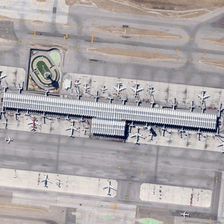

Predictions of RN50:
A busy airport with many aireplans.      100.0%
Satellite view of Hohai university.        0.0%
A building next to a lake.                 0.0%
Many people in a stadium.                  0.0%
a cute cat                                 0.0%


In [18]:
text_queries = [
    "A busy airport with many aireplans.", 
    "Satellite view of Hohai university.", 
    "A building next to a lake.", 
    "Many people in a stadium.", 
    "a cute cat",
    ]
text = tokenizer(text_queries)
image = Image.open("assets/airport.jpg")
display(image)

image = preprocess(image).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image.cuda())
    text_features = model.encode_text(text.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

print(f'Predictions of {model_name}:')
for query, prob in zip(text_queries, text_probs):
    print(f"{query:<40} {prob * 100:5.1f}%")